# Splitting data based on the user capacity

In [1]:
####Nonparametric meta learning
import pickle
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import argparse, os
import gpflow
from gpflow import kernels
from likelihoods import *
from data import *
from models import MLSVGP, BASESVGP
from meta_loop import meta_loop
from main import MAIN
from run_main import *
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf

observation_train = pickle.load(open('Inventory_norm_train70.pickle', 'rb'))
observation_test = pickle.load(open('Inventory_norm_test70.pickle', 'rb'))
observation_train = np.log(observation_train)
observation_test = np.log(observation_test)
prices = pickle.load(open('ActualPrices.pickle', 'rb'))
prices_random_train = prices[0 : observation_train.shape[1]].reshape(-1,1)
prices_random_test = prices[observation_train.shape[1]+1 :].reshape(-1,1)
C = np.array(pickle.load(open('LeasedSpace.pickle', 'rb')))
ids_train = np.zeros((observation_train.shape[0], observation_train.shape[1]))
ids_test = np.zeros((observation_test.shape[0], observation_test.shape[1]))


capacity_train = np.zeros((observation_train.shape[0], observation_train.shape[1]))
capacity_test = np.zeros((observation_test.shape[0], observation_test.shape[1]))

actual_price_train = np.zeros((observation_train.shape[0], observation_train.shape[1]))
actual_price_test = np.zeros((observation_test.shape[0], observation_test.shape[1]))

for i in range(observation_train.shape[0]):
    for j in range(observation_train.shape[1]):       
        ids_train[i, j]= i
        capacity_train[i, j] = C[i]
        actual_price_train[i,j] = prices_random_train[j]
        
for i in range(observation_test.shape[0]):
    for j in range(observation_test.shape[1]):       
        ids_test[i, j]= i
        capacity_test[i, j] = C[i]
        actual_price_test[i,j] = prices_random_test[j]
        
prior_observation_train = observation_train[:, :-1].reshape(-1,1)
prior_observation_test = np.concatenate((observation_train[:, -1:], observation_test[:, :-1]), axis =1).reshape(-1,1)


actual_observation_train = observation_train[:, 1:].reshape(-1,1)
actual_observation_test =  observation_test[:, :].reshape(-1,1)

User_capacity_train = capacity_train[:, :-1].reshape(-1,1)
User_capacity_test = np.concatenate((capacity_train[:, -1:], capacity_test[:, :-1]), axis =1).reshape(-1,1)

P_train = actual_price_train[:, 1:].reshape(-1,1)
P_test = actual_price_test[:, :].reshape(-1,1)

actual_ids_train =  ids_train[:, :-1].reshape(-1,1)
actual_ids_test =  ids_test.reshape(-1,1)


dataset_train= np.hstack((prior_observation_train, User_capacity_train, P_train , actual_observation_train , actual_ids_train))

dataset_test= np.hstack((prior_observation_test, User_capacity_test, P_test , actual_observation_test , actual_ids_test))



def create_model(**kwargs):
    if kwargs["model_name"] == "MLSVGP": 
        #kernel.clear() 
        kernel = kernels.RBF(kwargs["dim_in"] + kwargs["dim_h"], ARD=True)
        Z= np.random.randn(kwargs["n_inducing"], kwargs["dim_in"]+kwargs["dim_h"])
        mean_func = None
        likelihood = MultiGaussian(dim=kwargs["dim_out"])
        model = MLSVGP(
              dim_in=kwargs["dim_in"], dim_out=kwargs["dim_out"],
                dim_h=kwargs["dim_h"], num_h=kwargs["n_env"],
                kern=kernel, likelihood=likelihood, mean_function=mean_func,
                Z=Z, name=kwargs["model_name"])
        
    return model

#number of inducing points {10, 15, 20, 25, 30, 35}
num = 10

RMSerror= 0
kwargs= {"n_active_tasks": 4, "learning_rate": 0.1, "n_inducing" : num,  "batch_size": 10,
        "train_steps":400, "infer_steps": 100, "dim_in": 3, "dim_out":1, "dim_h": 1, "n_env":4, "meta_test_iters":0,
        "model_name": "MLSVGP","seed":1, "meta_train_iters": 20, "n_train_tasks":4}



model_NonPML = create_model(**kwargs)
Inference_NonPML = MAIN(model_NonPML, dataset_train, **kwargs) 
run_main(Inference_NonPML, dataset_train, dataset_train, **kwargs) 

N = observation_test.shape[0]
M = observation_test.shape[1]
xx_test= np.zeros((N,M,3))
experiment_path = "Proportional inventory-experiments-Non_parametric learning/70/"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
if not os.path.exists(experiment_path + "/experiment with {} inducing points/".format(num)):
    os.makedirs(experiment_path + "/experiment with {} inducing points/".format(num))
config_path = experiment_path + "/experiment with {} inducing points/ config.json".format(num)
with open(config_path, "w") as f:
    json.dump(kwargs, f)


for j in range(N):
    for dim in range(M):
        xx_test[j,dim,0] = observation_test[j, dim]
        xx_test[j,dim,1] = capacity_test[j, dim]
        xx_test[j,dim,2] = actual_price_test[j, dim]

def plot(xx, ids):
    ymu, yvar, hmu, hvar = Inference_NonPML.predict(xx, ids, True)
    img_path = experiment_path + "/experiment with {} inducing points/".format(num)
    if not os.path.exists(img_path):
        os.makedirs(img_path)
    for i in range(len(np.unique(ids))):
        img_path = experiment_path + "/experiment with {} inducing points/".format(num)
        img_path += "/img_user:{}.png".format(i)
        plt.figure()
        plt.plot(actual_price_test[0, :], observation_test[i, :].reshape(-1,1), 'kx', mew=0.5)
        plt.plot(actual_price_test[0, :], ymu[i,:,0] - 2*np.sqrt(yvar[i,:,0]), 'b*', alpha=0.3)
        plt.plot(actual_price_test[0, :], ymu[i,:,0] + 2*np.sqrt(yvar[i,:,0]), 'r*', alpha=0.3)    
        plt.xlabel('$Price$', fontsize=13)
        plt.ylabel('$y = f(x,h)$', fontsize=13)
        plt.title(('Non-parametric meta learning\n' 
                   'User:{}'. format(i+1)))
        plt.savefig(img_path)
    return ymu, yvar


y_mu, y_var = plot(xx_test, actual_ids_test.reshape(-1))

config_path = experiment_path + "/experiment with {} inducing points/RMSerror.json".format(num)
n_Trials = 10000
y_pred_NonPML = np.zeros((n_Trials, N, M))
for j in range(N):
    for i in range(M):
        for k in range(n_Trials):
            y_pred_NonPML[k, j, i] = np.random.normal(y_mu[j, i, 0], np.sqrt(y_var[j, i, 0]), 1)
#########################################
max_obs = 0
min_obs = 100000000000000000

for i in range(N):
    if max_obs < max(observation_test[i, :]):
        max_obs =  max(observation_test[i, :])
    if min_obs > min(observation_test[i, :]):
        min_obs =  min(observation_test[i, :])
#############################################################

for k in range(n_Trials):
    RMSerror += sum(sum((observation_test[:, :] - y_pred_NonPML[k, :, :])**2))
RMSerror_NonPML = []
RMSerror_NonPML.append(np.sqrt(RMSerror/ (n_Trials*N*M))/(max_obs -min_obs))
RMS_NonPML = {}
RMS_NonPML['RMSerror'] = RMSerror_NonPML
with open(config_path, "w") as f:
    json.dump(RMSerror_NonPML, f)


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


[1.0]
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.
  0%|          | 0/400 [00:00<?, ?it/s]

Training model..


  2%|▏         | 7/400 [00:00<00:06, 60.58it/s]

-3.2846613252626016
Meta iteration 1/20
Training model..


  0%|          | 0/400 [00:00<?, ?it/s]

-2.7660133144850976
H_mu: [[ 0.00362718]
 [ 0.11675913]
 [ 0.05407468]
 [-0.03175614]]
H_var: [[0.89230739]
 [0.86917551]
 [0.73628104]
 [0.86167907]]
H_error: [[1.88924047]
 [1.86459166]
 [1.7161364 ]
 [1.8565334 ]]
lik_noise: [0.03853242]
kern_var: 0.7071066717213539
kern_ls: [ 4.43491751  3.0472546  51.76496092 48.87580404]
Meta iteration 2/20
Training model..


  2%|▏         | 7/400 [00:00<00:05, 68.03it/s]

-11.126057297127968
H_mu: [[ 0.00293125]
 [-0.01307383]
 [ 0.00175705]
 [ 0.04571799]]
H_var: [[0.9181872 ]
 [0.97004406]
 [0.99180263]
 [0.83130247]]
H_error: [[1.9164417 ]
 [1.96981629]
 [1.99178576]
 [1.8235158 ]]
lik_noise: [0.03814901]
kern_var: 0.8634754583031787
kern_ls: [ 4.868201    3.36534259 75.89602252 77.10723437]
Meta iteration 3/20
Training model..


  2%|▏         | 7/400 [00:00<00:06, 58.19it/s]

-10.557355376920306
H_mu: [[ 0.03777941]
 [-0.02798758]
 [ 0.02368191]
 [ 0.03684963]]
H_var: [[1.03320621]
 [0.97752161]
 [0.97645556]
 [0.98071148]]
H_error: [[2.03293503]
 [1.97739385]
 [1.97631532]
 [1.98061756]]
lik_noise: [0.03932045]
kern_var: 0.8078149043475352
kern_ls: [  4.73355214   3.42228054 105.38413103 119.31794819]
Meta iteration 4/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 55.73it/s]

-14.560899832099963
H_mu: [[-0.01172902]
 [ 0.02307149]
 [ 0.00197808]
 [-0.0260692 ]]
H_var: [[1.01345215]
 [1.00270013]
 [0.95525897]
 [0.94114942]]
H_error: [[2.01340721]
 [2.0026983 ]
 [1.95474701]
 [1.94025711]]
lik_noise: [0.03388032]
kern_var: 0.9283824502064046
kern_ls: [  4.99173327   3.60324919 156.80926    186.81850065]
Meta iteration 5/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 54.07it/s]

-9.385324884767401
H_mu: [[-0.0366382 ]
 [-0.00321212]
 [ 0.00569522]
 [-0.00942475]]
H_var: [[0.97371855]
 [1.01671235]
 [0.96817473]
 [0.96872059]]
H_error: [[1.97354356]
 [2.0166431 ]
 [1.96791741]
 [1.96847208]]
lik_noise: [0.04443601]
kern_var: 1.0159499562635064
kern_ls: [  4.98056136   3.53383569 232.78848706 276.94096942]
Meta iteration 6/20
Training model..


  2%|▏         | 6/400 [00:00<00:06, 59.75it/s]

-6.574367073485884
H_mu: [[-0.00371345]
 [-0.00673211]
 [ 0.02754132]
 [-0.02031197]]
H_var: [[0.98648513]
 [1.01792448]
 [0.97356586]
 [1.00686111]]
H_error: [[1.98643915]
 [2.01784487]
 [1.97338882]
 [2.00684939]]
lik_noise: [0.04235903]
kern_var: 1.018066354437542
kern_ls: [  5.12552284   3.76634763 329.70755174 385.13887112]
Meta iteration 7/20
Training model..


  2%|▏         | 6/400 [00:00<00:06, 58.46it/s]

-3.0912056948510847
H_mu: [[ 0.00410874]
 [-0.02542225]
 [-0.00256581]
 [ 0.01182666]]
H_var: [[0.99718715]
 [0.96951501]
 [0.99548145]
 [1.01889596]]
H_error: [[1.99718517]
 [1.96927907]
 [1.99547634]
 [2.01880753]]
lik_noise: [0.04242427]
kern_var: 0.9914284890246126
kern_ls: [  5.22039454   3.80694817 457.55567632 546.91660357]
Meta iteration 8/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 52.82it/s]

-14.289467346425676
H_mu: [[-0.00070255]
 [-0.00552303]
 [ 0.00838121]
 [-0.00112054]]
H_var: [[1.00795284]
 [0.99961659]
 [0.99696707]
 [0.99811997]]
H_error: [[2.00793709]
 [1.99961655]
 [1.99696477]
 [1.99811909]]
lik_noise: [0.03517773]
kern_var: 1.0030497996055425
kern_ls: [  4.90223687   3.68819782 590.2193439  743.99357136]
Meta iteration 9/20
Training model..


  2%|▏         | 7/400 [00:00<00:06, 64.98it/s]

-5.786435935648218
H_mu: [[0.00366348]
 [0.00018771]
 [0.00047468]
 [0.00693288]]
H_var: [[1.00210663]
 [0.98377821]
 [1.00446369]
 [0.99326482]]
H_error: [[2.00210552]
 [1.98371189]
 [2.00445872]
 [1.99325344]]
lik_noise: [0.04029689]
kern_var: 0.9207308459520867
kern_ls: [  4.93473838   3.60569138 696.34048771 967.14192823]
Meta iteration 10/20
Training model..


  2%|▏         | 6/400 [00:00<00:06, 57.04it/s]

-14.948159573002531
H_mu: [[ 0.00797131]
 [-0.00185003]
 [ 0.00067841]
 [-0.00792779]]
H_var: [[1.00132291]
 [1.00585391]
 [1.00657843]
 [1.00714683]]
H_error: [[2.00132248]
 [2.00584537]
 [2.00656764]
 [2.00713411]]
lik_noise: [0.03776617]
kern_var: 0.9378908710054558
kern_ls: [   5.00763143    3.68615322  831.5655606  1197.68360223]
Meta iteration 11/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 50.93it/s]

14.564035760715267
H_mu: [[-0.00085466]
 [ 0.00125571]
 [ 0.00047291]
 [-0.00042555]]
H_var: [[1.00051415]
 [0.99653624]
 [1.00011951]
 [0.99755264]]
H_error: [[2.00051408]
 [1.99653323]
 [2.00011951]
 [1.99755115]]
lik_noise: [0.08927901]
kern_var: 0.9052358971034453
kern_ls: [   5.056735      3.59264738 1029.91451289 1449.74930456]
Meta iteration 12/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 54.09it/s]

-0.21007791188541916
H_mu: [[-7.53206792e-04]
 [ 2.28140694e-05]
 [ 7.15168415e-05]
 [-1.91522603e-02]]
H_var: [[1.00025158]
 [1.00038903]
 [0.99513443]
 [0.99469998]]
H_error: [[2.00025157]
 [2.000389  ]
 [1.9951285 ]
 [1.99469293]]
lik_noise: [0.04804367]
kern_var: 0.953149830345201
kern_ls: [   4.89104547    3.67502333 1207.82851634 1561.88420139]
Meta iteration 13/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 55.81it/s]

-16.848948621008397
H_mu: [[ 0.00424132]
 [ 0.00870255]
 [-0.00898512]
 [ 0.06201691]]
H_var: [[1.00025195]
 [0.99296439]
 [1.00026529]
 [1.02495669]]
H_error: [[2.00025193]
 [1.99295197]
 [2.00026527]
 [2.0248029 ]]
lik_noise: [0.03259043]
kern_var: 0.9565809724395703
kern_ls: [   4.95682138    3.64575733 1426.31804855 1781.82051049]
Meta iteration 14/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 55.75it/s]

1.5015553244076827
H_mu: [[-0.00362585]
 [ 0.01615764]
 [-0.00135442]
 [ 0.00214736]]
H_var: [[1.00822497]
 [0.99451318]
 [1.00579349]
 [1.00118763]]
H_error: [[2.00820813]
 [1.99450563]
 [2.00578512]
 [2.00118728]]
lik_noise: [0.0400435]
kern_var: 1.0680383441636039
kern_ls: [   5.24077946    3.76985356 1635.85776884 2034.3365581 ]
Meta iteration 15/20
Training model..


  2%|▏         | 7/400 [00:00<00:06, 60.37it/s]

-3.7503078088503186
H_mu: [[ 0.00013381]
 [ 0.00041738]
 [ 0.00023806]
 [-0.00010218]]
H_var: [[1.00035534]
 [0.99933123]
 [1.00173755]
 [1.00032847]]
H_error: [[2.00035531]
 [1.99933112]
 [2.0017368 ]
 [2.00032844]]
lik_noise: [0.03370602]
kern_var: 0.789944930899958
kern_ls: [   4.71289389    3.39547506 1827.39827335 2274.40717176]
Meta iteration 16/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 52.38it/s]

-9.30221684861834
H_mu: [[-7.26239412e-05]
 [ 1.89225744e-04]
 [-9.74142829e-04]
 [-2.07043669e-02]]
H_var: [[0.99818153]
 [0.99993046]
 [1.00550434]
 [1.00054737]]
H_error: [[1.9981807 ]
 [1.99993046]
 [2.00549679]
 [2.00054729]]
lik_noise: [0.03736188]
kern_var: 0.88019935759851
kern_ls: [   5.05840151    3.56639314 2087.28820878 2536.48707426]
Meta iteration 17/20
Training model..


  2%|▏         | 6/400 [00:00<00:07, 53.50it/s]

-4.580814029040271
H_mu: [[-2.84199696e-04]
 [ 8.68089513e-04]
 [ 5.10675493e-05]
 [ 1.99717557e-05]]
H_var: [[0.999242  ]
 [0.99927348]
 [1.00028649]
 [1.00057239]]
H_error: [[1.99924185]
 [1.99927334]
 [2.00028647]
 [2.00057231]]
lik_noise: [0.0415399]
kern_var: 0.3635212476665337
kern_ls: [4.08705816e+00 2.74650465e+00 2.27230450e+03 2.74751269e+03]
Meta iteration 18/20
Training model..


  1%|▏         | 5/400 [00:00<00:08, 46.51it/s]

-7.143423615791124
H_mu: [[ 4.79606311e-05]
 [-6.77970208e-04]
 [-2.27554557e-03]
 [ 1.04767553e-02]]
H_var: [[1.00450883]
 [0.99989996]
 [0.99844586]
 [1.00004544]]
H_error: [[2.00450376]
 [1.99989996]
 [1.99844526]
 [2.00004544]]
lik_noise: [0.03957934]
kern_var: 0.8874975702331871
kern_ls: [   4.85017884    3.52709165 2283.6341695  2843.30078996]
Meta iteration 19/20
Training model..


  1%|▏         | 5/400 [00:00<00:08, 46.60it/s]

-11.09213251596955
H_mu: [[ 0.0013975 ]
 [-0.00104763]
 [-0.00091381]
 [ 0.00021101]]
H_var: [[1.00151575]
 [0.99972918]
 [1.00069671]
 [0.99939545]]
H_error: [[2.00151518]
 [1.99972916]
 [2.00069659]
 [1.99939536]]
lik_noise: [0.03270148]
kern_var: 0.8616906640460711
kern_ls: [   5.03215305    3.54875144 2296.41956017 3058.46999446]
Meta iteration 20/20
Training model..


  1%|▏         | 5/400 [00:00<00:08, 47.57it/s]

1.207059308775587
H_mu: [[0.00099882]
 [0.00502864]
 [0.00086172]
 [0.00074027]]
H_var: [[1.00075991]
 [0.99977723]
 [1.00274668]
 [0.99869824]]
H_error: [[2.00075977]
 [1.99977722]
 [2.00274479]
 [1.99869782]]
lik_noise: [0.05066857]
kern_var: 0.955392009421045
kern_ls: [   5.26799713    3.86467536 2371.04969963 3300.51687952]
Training model..


100%|██████████| 400/400 [00:07<00:00, 50.90it/s]


-7.436786194719916
(48, 3)
H_mu [[ 3.24468731e-04]
 [ 1.51931013e-04]
 [-1.32128567e-02]
 [-7.77450208e-05]]
H_var [[1.00120582]
 [0.99917358]
 [0.99963241]
 [1.00052595]]
ML: [12.08490058] [0.28443039]


In [2]:
RMSerror_NonPML

[2.834317577363397]

In [3]:
##############
#Finding the best overbooking level, alpha

p = 1
c = 1.2
T_capacity = 1235000
max_prof = 0
dscontfac = 0.99
Total_cost = 0
prof_lst = []
for alpha in np.arange(0, 1, 0.01):
    revenue = (alpha+1) *T_capacity *p 
    for time in range(M):
        unitcost = 0
        for itr in range(n_Trials):
            sum_inv = 0
            for user in range(N):
                sum_inv += y_pred_NonPML[itr,  user, time]
            if (1-alpha)*T_capacity < sum_inv:
                unitcost += c*(-(1-alpha)*T_capacity + sum_inv)
        average_cost= unitcost/n_Trials
        discounted_cost = (dscontfac**time) * average_cost
        Total_cost += discounted_cost
    profit = revenue - Total_cost
    prof_lst.append(profit)
    if profit > max_prof:
        opt_prof = profit
        opt_alpha = alpha
    

config_path = experiment_path + "/experiment with {} inducing points/alpha.json".format(num)
            
overbooking_value = {}
overbooking_value['alpha'] = opt_alpha
with open(config_path, "w") as f:
    json.dump(overbooking_value, f)        
    

(-10000000.0, 10000000.0)

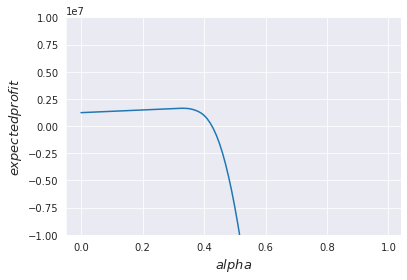

In [4]:
plt.plot(np.arange(0, 1, 0.01), prof_lst)
plt.xlabel('$alpha$', fontsize=13)
plt.ylabel('$expected profit$', fontsize=13)
plt.ylim(-1e7, 1e7)